# Skin Lesion Classification - Machine Learning and Computer Vision Project #

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fanconic/skin-cancer-malignant-vs-benign")

print("Path to dataset files:", path)

/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 325M/325M [01:19<00:00, 4.28MB/s] 

Extracting files...


Path to dataset files: /Users/arnavkarnik/.cache/kagglehub/datasets/fanconic/skin-cancer-malignant-vs-benign/versions/4


In [16]:
import os
import pandas as pd
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from skimage.measure import shannon_entropy
from sklearn.decomposition import PCA
from skimage import feature
from tqdm import tqdm
from scipy.stats import skew
from skimage.feature import graycomatrix, graycoprops
from skimage.util import img_as_ubyte
from skimage.filters import threshold_otsu
import pywt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

def load_dataset(folder_path):
    data = []
    labels = []
    for label in ['malignant', 'benign']:
        folder = os.path.join(folder_path, label)
        for img_name in tqdm(os.listdir(folder), desc=f"Loading {label} images"):
            if not img_name.endswith(('jpg', 'png', 'jpeg')):  # Skip non-image files
                continue
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                data.append(img)
                labels.append(label)
    return np.array(data), np.array(labels)

# Set the path to your Kaggle dataset location
data_path = "/Users/arnavkarnik/Documents/Skin-Lesions-classifications-and-Development-of-GUI/dataset"

# Load train and test sets
train_data, train_labels = load_dataset(os.path.join(data_path, "train"))
test_data, test_labels = load_dataset(os.path.join(data_path, "test"))

# Convert labels to binary format
train_labels = np.where(train_labels == 'benign', 0, 1)
test_labels = np.where(test_labels == 'benign', 0, 1)

def extract_shape_features(img):
    features = []
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter != 0 else 0
        features.extend([area, perimeter, circularity])
        if len(cnt) >= 5:
            (x, y), (MA, ma), angle = cv2.fitEllipse(cnt)
            asymmetry = MA / ma if ma != 0 else 0
            features.append(asymmetry)
        else:
            features.append(0)
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area if hull_area != 0 else 0
        features.append(solidity)
    else:
        features.extend([0] * 5)
    return np.array(features).ravel()

def extract_texture_features(img):
    features = []
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, 8 * 3, 3, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 8 * 3 + 3), range=(0, 8 * 3 + 2))
    features.extend(hist)
    glcm = graycomatrix(gray, [5], [0], 256, symmetric=True, normed=True)
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
        features.append(graycoprops(glcm, prop)[0, 0])
    return np.array(features).ravel()

def extract_color_features(img):
    features = []
    for i in range(3):
        channel = img[:,:,i]
        non_zero_pixels = channel[channel != 0]
        if non_zero_pixels.size > 0:
            mean, std_dev, skewness = non_zero_pixels.mean(), non_zero_pixels.std(), skew(non_zero_pixels.ravel())
            features.extend([mean, std_dev, skewness])
        else:
            features.extend([0, 0, 0])
        hist = cv2.calcHist([img], [i], None, [32], [0, 1])
        features.extend(hist.flatten())
    return np.array(features).ravel()

def extract_gabor_features(img, num_kernels=8):
    gabor_features = []
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    for theta in np.arange(0, np.pi, np.pi / num_kernels):
        kernel = cv2.getGaborKernel((31, 31), sigma=4.0, theta=theta, lambd=10.0, gamma=0.5, psi=0)
        filtered_img = cv2.filter2D(img_gray, cv2.CV_8UC3, kernel)
        mean, std_dev = cv2.meanStdDev(filtered_img)
        gabor_features.extend([mean[0][0], std_dev[0][0]])
    return gabor_features

def extract_hog_features(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hog_features, _ = hog(img_gray, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)
    return hog_features

def extract_edge_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edge_density = np.sum(edges) / (edges.shape[0] * edges.shape[1])
    return [edge_density]

def fractal_dimension(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    threshold = threshold_otsu(gray)
    bin_img = gray < threshold
    sizes = []
    
    # Generate box sizes and calculate number of non-zero pixels at each size
    box_sizes = np.arange(1, 50, 2)
    for box_size in box_sizes:
        resized_img = cv2.resize(bin_img.astype(np.uint8), (box_size, box_size), interpolation=cv2.INTER_NEAREST)
        sizes.append(np.sum(resized_img > 0))
    
    # Remove zero values to avoid log(0) issues
    sizes = [size for size in sizes if size > 0]
    
    # Check if we have enough data points to fit a line
    if len(sizes) > 1:
        # Use matching lengths for x and y
        return [np.polyfit(np.log(box_sizes[:len(sizes)]), np.log(sizes), 1)[0]]
    else:
        # Return 0 if there aren't enough data points
        return [0]


def extract_wavelet_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    coeffs = pywt.wavedec2(gray, 'db1', level=2)
    wavelet_features = []
    for level in coeffs:
        for arr in level:
            wavelet_features.extend([np.mean(arr), np.std(arr)])
    return wavelet_features

def extract_entropy_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    entropy_value = shannon_entropy(gray)
    return [entropy_value]

def analyze_lesion(img):
    color_features = extract_color_features(img)
    texture_features = extract_texture_features(img)
    shape_features = extract_shape_features(img)
    gabor_features = extract_gabor_features(img)
    hog_features = extract_hog_features(img)
    edge_features = extract_edge_features(img)
    fractal_features = fractal_dimension(img)
    wavelet_features = extract_wavelet_features(img)
    entropy_features = extract_entropy_features(img)
    return np.concatenate([color_features, texture_features, shape_features, gabor_features, hog_features, edge_features, fractal_features, wavelet_features, entropy_features])

def process_dataset(data, labels):
    features = []
    for img in tqdm(data, desc="Processing images"):
        img_features = analyze_lesion(img)
        features.append(img_features)
    features = np.array(features)
    return features, labels

# Process train and test sets
X_train_raw, y_train = process_dataset(train_data, train_labels)
X_test_raw, y_test = process_dataset(test_data, test_labels)

# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_raw = imputer.fit_transform(X_train_raw)
X_test_raw = imputer.transform(X_test_raw)

# Standardize the features
scaler = StandardScaler()
X_train_raw = scaler.fit_transform(X_train_raw)
X_test_raw = scaler.transform(X_test_raw)

# Apply PCA
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train_raw)
X_test = pca.transform(X_test_raw)


Processing images: 100%|██████████| 660/660 [00:23<00:00, 28.41it/s]


SVM Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': np.float64(46.41588833612773)}
SVM Best Score: 0.7622239951699156

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       360
           1       0.80      0.75      0.77       300

    accuracy                           0.80       660
   macro avg       0.80      0.79      0.80       660
weighted avg       0.80      0.80      0.80       660


MLP Best Parameters: {'solver': 'adam', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (50,), 'alpha': np.float64(0.1), 'activation': 'relu'}
MLP Best Score: 0.7550227128974757

MLP Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.81       360
           1       0.75      0.81      0.78       300

    accuracy                           0.79       660
   macro avg       0.79      0.80      0.79       660
weighted avg       0.80      0.79  

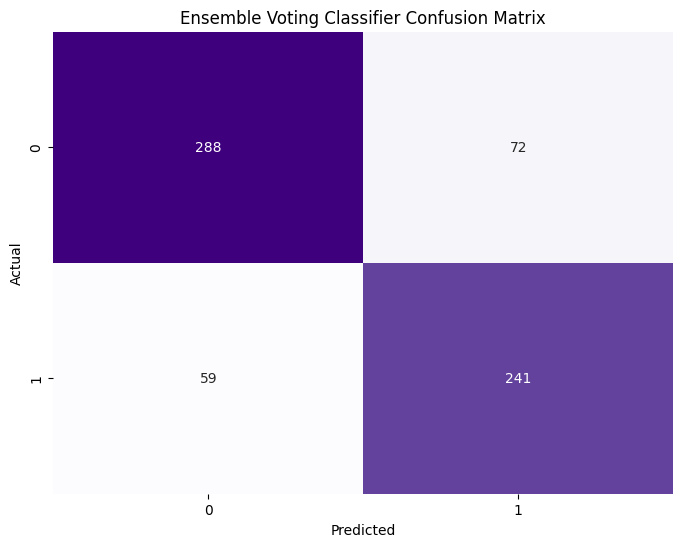

In [22]:
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dimensionality Reduction with PCA
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# SVM with extended parameter grid and RandomizedSearchCV
svm_param_dist = {
    'C': np.logspace(-3, 3, 10),
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}
# Update SVM to enable probability predictions for ensemble
svm_random = RandomizedSearchCV(SVC(random_state=42, probability=True), svm_param_dist, cv=5, n_jobs=-1, n_iter=20, random_state=42)
svm_random.fit(X_train_pca, y_train)

print("SVM Best Parameters:", svm_random.best_params_)
print("SVM Best Score:", svm_random.best_score_)

# Predictions and evaluation for SVM
svm_pred = svm_random.predict(X_test_pca)
print("\nSVM Classification Report:")
print(classification_report(y_test, svm_pred))

# MLP with RandomizedSearchCV and extended parameter grid
mlp_param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': np.logspace(-5, -1, 5),
    'learning_rate': ['constant', 'adaptive'],
    'solver': ['adam', 'sgd']
}
mlp_random = RandomizedSearchCV(MLPClassifier(random_state=42, max_iter=2000), mlp_param_dist, cv=5, n_jobs=-1, n_iter=20, random_state=42)
mlp_random.fit(X_train_pca, y_train)

print("\nMLP Best Parameters:", mlp_random.best_params_)
print("MLP Best Score:", mlp_random.best_score_)

# Predictions and evaluation for MLP
mlp_pred = mlp_random.predict(X_test_pca)
print("\nMLP Classification Report:")
print(classification_report(y_test, mlp_pred))

# Ensemble Voting Classifier with probability-enabled SVM, MLP, and Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
voting_clf = VotingClassifier(estimators=[('svm', svm_random.best_estimator_), ('mlp', mlp_random.best_estimator_), ('rf', rf)], voting='soft')
voting_clf.fit(X_train_pca, y_train)

# Evaluate Ensemble Model
voting_pred = voting_clf.predict(X_test_pca)
print("\nEnsemble Voting Classifier Classification Report:")
print(classification_report(y_test, voting_pred))

# Plot Confusion Matrix for the Ensemble
plt.figure(figsize=(8, 6))
ensemble_cm = confusion_matrix(y_test, voting_pred)
sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Purples', cbar=False)
plt.title("Ensemble Voting Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



Random Forest Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest Best Score: 0.7497239951699155

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       360
           1       0.83      0.62      0.71       300

    accuracy                           0.77       660
   macro avg       0.78      0.76      0.76       660
weighted avg       0.78      0.77      0.76       660



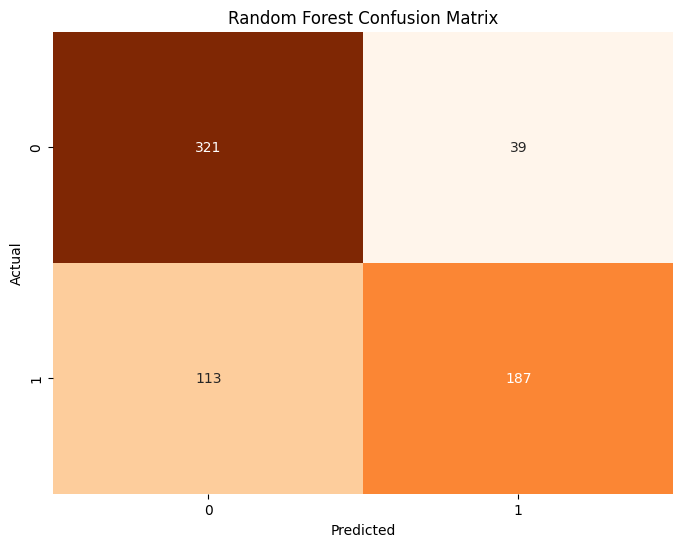

In [18]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model with Grid Search
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, n_jobs=-1)
rf_grid.fit(X_train_scaled, y_train)

print("\nRandom Forest Best Parameters:", rf_grid.best_params_)
print("Random Forest Best Score:", rf_grid.best_score_)

# Predictions and evaluation for Random Forest
rf_pred = rf_grid.predict(X_test_scaled)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred))

# Plot Random Forest Confusion Matrix
plt.figure(figsize=(8, 6))
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


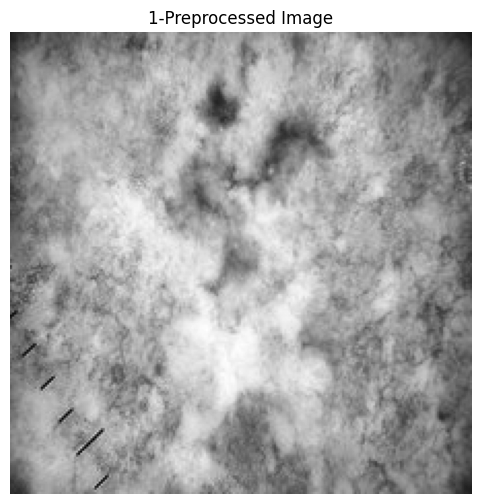

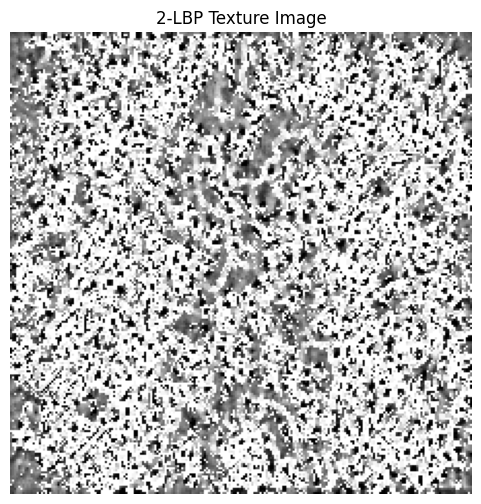

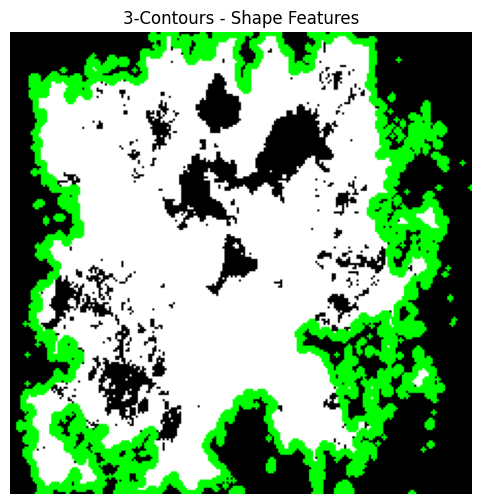

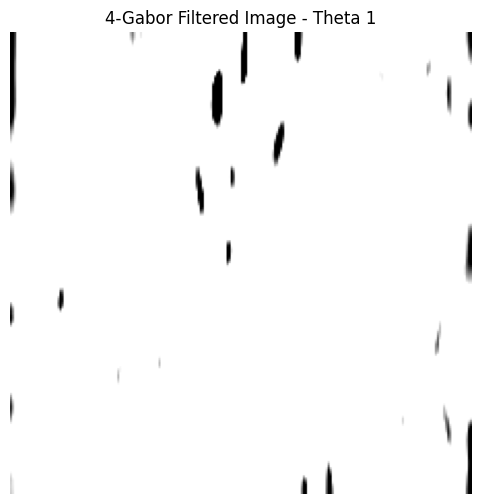

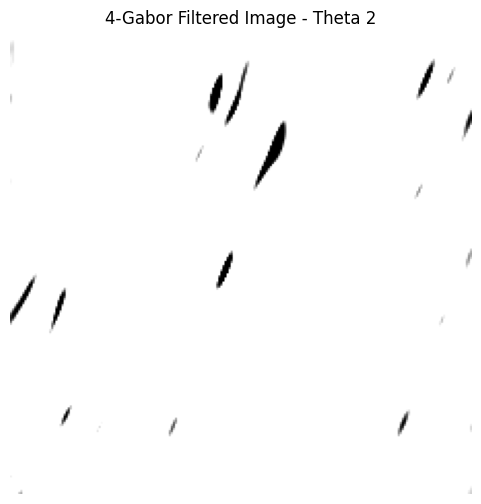

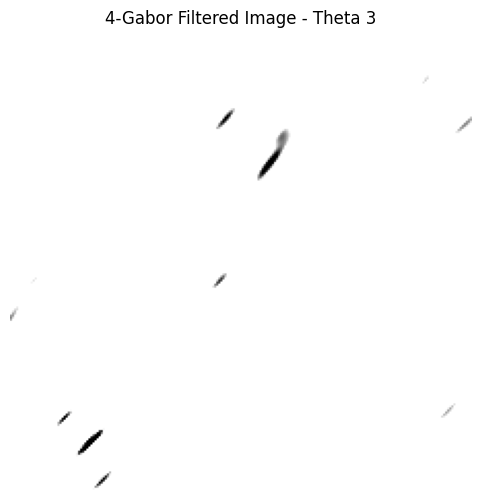

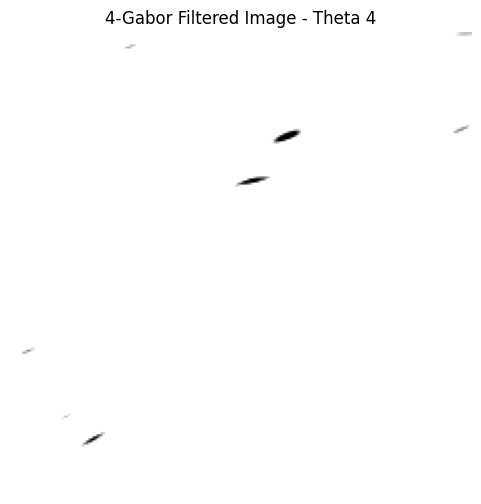

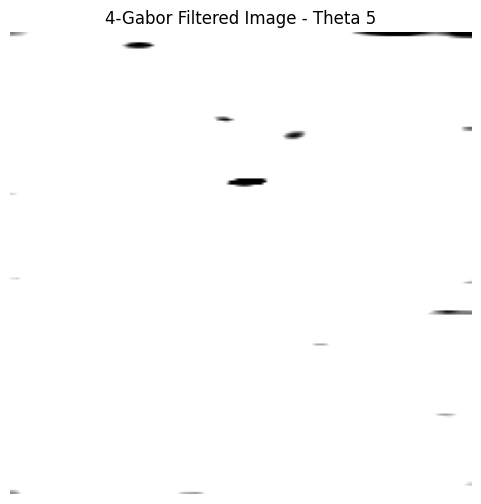

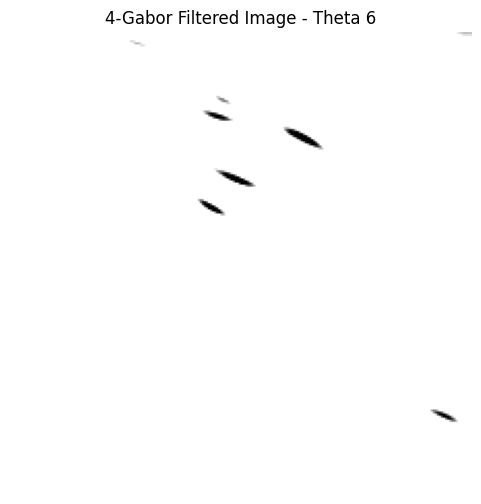

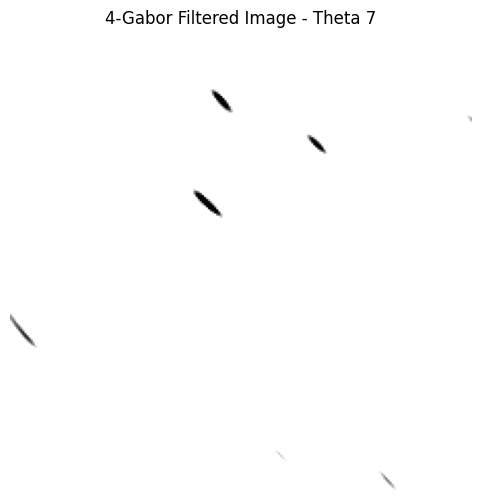

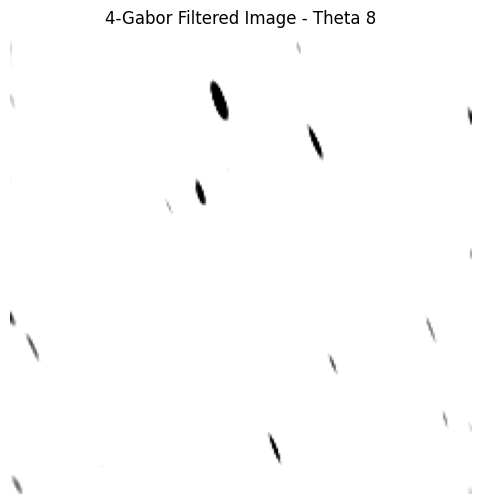

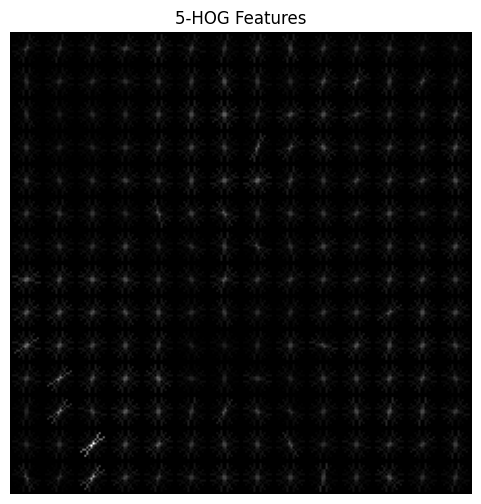

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern, hog
from tqdm import tqdm

output_folder = "output_images"
os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

def save_and_show_image(image, step_name, is_feature=False):
    """Save and show images or feature plots."""
    file_path = os.path.join(output_folder, f"{step_name}.png")
    
    plt.figure(figsize=(6, 6))
    if is_feature:
        plt.plot(image)  # Feature array visualization
        plt.title(f"{step_name} - Feature Array")
    else:
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        plt.axis('off')
        plt.title(step_name)
    
    plt.savefig(file_path)
    plt.show()

def ensure_grayscale(image):
    """Convert image to grayscale if it's not already."""
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image

# Sample image preprocessing
sample_image = preprocess_image(train_data[0])  # Assuming preprocess_image is defined
save_and_show_image(sample_image, "1-Preprocessed Image")

# Grayscale conversion for LBP and shape features
gray_img = ensure_grayscale(sample_image)

# Local Binary Pattern (LBP) texture feature
lbp_image = local_binary_pattern(gray_img, P=24, R=3, method='uniform')
save_and_show_image(lbp_image, "2-LBP Texture Image")

# Binary thresholding & contour visualization for shape features
_, binary = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
save_and_show_image(contour_img, "3-Contours - Shape Features")

# Gabor filter visualizations with various theta values
for i, theta in enumerate(np.linspace(0, np.pi, 8, endpoint=False)):
    kernel = cv2.getGaborKernel((31, 31), sigma=4.0, theta=theta, lambd=10.0, gamma=0.5, psi=0)
    gabor_image = cv2.filter2D(gray_img, cv2.CV_8UC3, kernel)
    save_and_show_image(gabor_image, f"4-Gabor Filtered Image - Theta {i+1}")

# Histogram of Oriented Gradients (HOG) visualization
hog_features, hog_image = hog(gray_img, orientations=8, pixels_per_cell=(16, 16),
                              cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)
save_and_show_image(hog_image, "5-HOG Features")
